In [21]:
#importing useful modeuls
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
import os
import glob
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader

In [22]:
root = "stage1_train"
folders = [d for d in os.listdir(root) if os.path.isdir(os.path.join(root, d))]

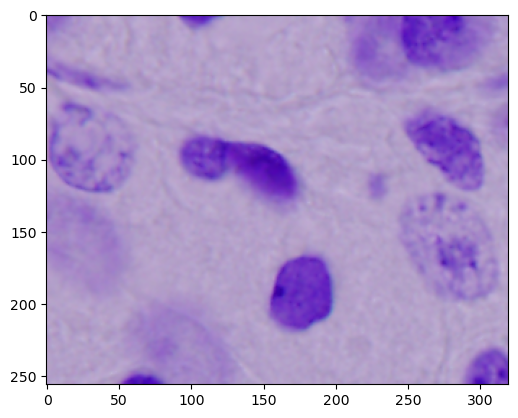

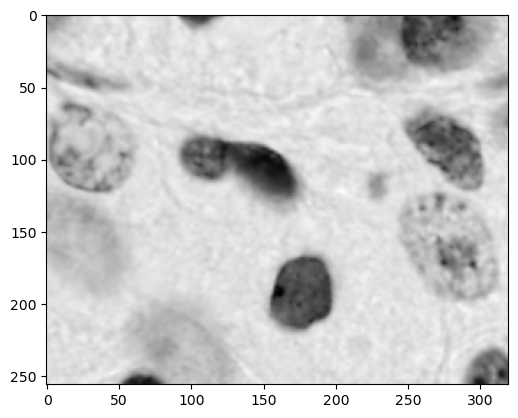

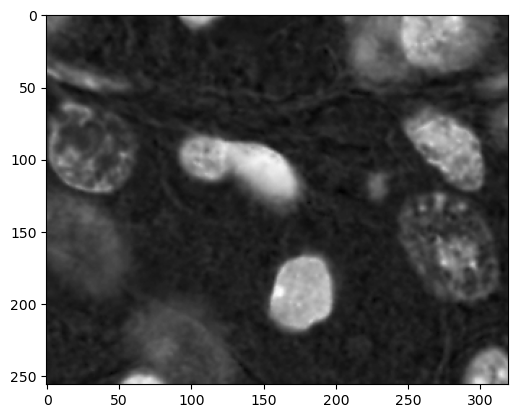

(256, 320) uint8


In [23]:
#example training colored image, grayscale and inverted gray scale
purple_background = r"stage1_train\1e488c42eb1a54a3e8412b1f12cde530f950f238d71078f2ede6a85a02168e1f\images\1e488c42eb1a54a3e8412b1f12cde530f950f238d71078f2ede6a85a02168e1f.png"
img = mpl.image.imread(purple_background)
plt.imshow(img)
plt.show()

img = Image.open(purple_background).convert("L")
arr = np.array(img)
plt.imshow(arr, cmap = "gray")
plt.show()
plt.imshow(255 - arr, cmap = "gray")
plt.show()
print(arr.shape, arr.dtype)

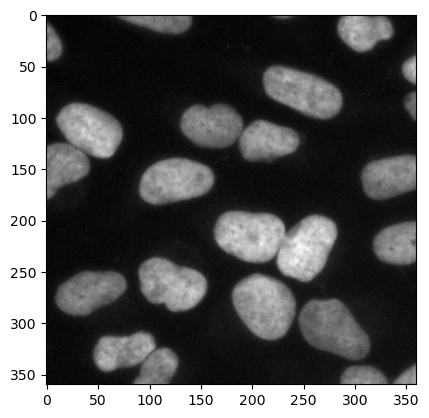

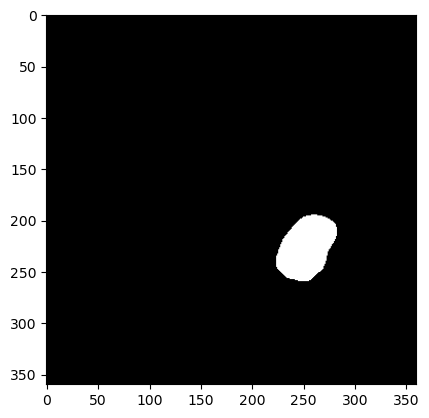

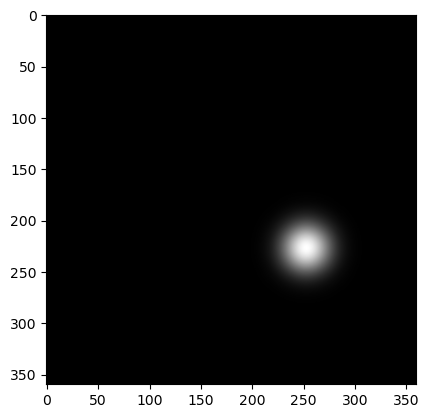

In [24]:
#example training gaussian density creation for one cell instance mask
mask_image_trial_path = r"stage1_train\ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d19659189951f540f48\images\ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d19659189951f540f48.png"
img = Image.open(mask_image_trial_path).convert("L")
arr = np.array(img)
plt.imshow(arr, cmap = "gray")
plt.show()

mask_trial_path = r"stage1_train\ff599c7301daa1f783924ac8cbe3ce7b42878f15a39c2d19659189951f540f48\masks\e8b0ca2abdae3ad9ef68c59f6cd90cab733a10589d3853e2f111e6f5f490cdcc.png"
img = Image.open(mask_trial_path).convert("L")
arr = np.array(img)
arr = arr/255
plt.imshow(arr, cmap = "gray")
plt.show()

#mapping pixel to x and y position
x_pos = np.tile(np.array([np.arange(1, arr.shape[1] + 1)]), (arr.shape[0], 1))
y_pos = np.tile(np.array([np.arange(1, arr.shape[0] + 1)]).T, (1, arr.shape[1]))

#counting cell area by summing pixels
cell_area = np.sum(arr)

#calculating x and y positions of centroid
mu_x = np.sum(x_pos * arr) / cell_area
mu_y = np.sum(y_pos * arr) / cell_area

#var_factor represents how peaked the gaussian would be and var scales it according to cell area
var_factor = 0.2
var = var_factor * cell_area
gauss = np.exp(-((x_pos - mu_x) ** 2 + (y_pos - mu_y) ** 2) / var)
plt.imshow(gauss / np.sum(gauss), cmap = "gray")
plt.show()


In [25]:
# # loop used to create density map training labels

# var_factor = 0.2

# for i, name in enumerate(folders):
#     full_path = os.path.join(root, name)
#     density_path = os.path.join(full_path, f"density_varfactor{var_factor}.npy")
#     force = False
#     if os.path.exists(density_path) and not force:
#         continue
#     masks_trial_path = full_path

#     mask_trial_paths = glob.glob(os.path.join(masks_trial_path, "masks", "*"))

#     full_image_path = glob.glob(os.path.join(masks_trial_path, "images", "*"))
#     full_image = Image.open(full_image_path[0]).convert("L")
#     full_image_arr = np.array(full_image, dtype=np.float32)
#     full_image_arr = full_image_arr/255
#     train_label = np.zeros_like(full_image_arr, dtype=np.float32)
#     H, W = full_image_arr.shape
#     y_pos, x_pos = np.mgrid[0:H, 0:W].astype(np.float32)

#     for mask_trial_path in mask_trial_paths:
#         img = Image.open(mask_trial_path).convert("L")
#         arr = (np.array(img) > 0).astype(np.float32)

#         cell_area = np.sum(arr)

#         if cell_area == 0:
#             continue

#         mu_x = np.sum(x_pos * arr) / cell_area

#         mu_y = np.sum(y_pos * arr) / cell_area

#         var = max(var_factor * cell_area, 1e-6)
#         gauss = np.exp(-((x_pos - mu_x) ** 2 + (y_pos - mu_y) ** 2) / var)

#         train_label = train_label + gauss / np.sum(gauss)

#     np.save(density_path, train_label.astype(np.float32))

In [26]:
#saving training data as .npy files to load later as grayscale image arrays

# for i, name in enumerate(folders):
#     full_path = os.path.join(root, name)

#     full_image_path = glob.glob(os.path.join(full_path, "images", "*"))
#     full_image = Image.open(full_image_path[0]).convert("L")
#     full_image_arr = np.array(full_image)
#     full_image_arr = full_image_arr/255

#     np.save(os.path.join(full_path, f"image"), full_image_arr.astype(np.float32))

In [ ]:
# Defining the U-Net model

class DoubleConv(nn.Module):
    def __init__(self, in_ch: int, out_ch: int) -> None:
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.GroupNorm(8, out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_ch, H, W) float tensor
        Returns:
            (N, out_ch, H, W) float tensor
        """
        return self.net(x)

class Down(nn.Module):
    def __init__(self, in_ch: int, out_ch: int) -> None:
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x: (N, in_ch, H, W)
        Returns:
            (N, out_ch, H/2, W/2)
        """
        return self.conv(self.pool(x))

class Up(nn.Module):
    def __init__(self, in_ch: int, skip_ch: int, out_ch: int) -> None:
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear")
        self.reduce = nn.Conv2d(in_ch, in_ch // 2, kernel_size=1, bias=False)
        up_ch = in_ch // 2
        self.conv = DoubleConv(up_ch + skip_ch, out_ch)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x:    (N, in_ch,   H,   W)
            skip: (N, skip_ch, 2H,  2W)
        Returns:
            (N, out_ch, 2H, 2W)
        """
        x = self.up(x)
        x = self.reduce(x)
        x = torch.cat([skip, x], dim=1)
        return self.conv(x)

class UNetDensity(nn.Module):
    def __init__(self, in_channels: int = 1, base: int = 16, out_activation: str = "relu") -> None:
        super().__init__()
        c1, c2, c3, c4, c5 = base, base*2, base*4, base*8, base*16

        self.inc = DoubleConv(in_channels, c1) #from 1 to 16 channels
        self.d1  = Down(c1, c2) #16 to 32 channels
        self.d2  = Down(c2, c3) #32 to 64 channels
        self.d3  = Down(c3, c4) #64 to 128 channels
        self.d4  = Down(c4, c5) #128 to 256 channels

        self.u1 = Up(c5, c4, c4) #128 from 256 channels
        self.u2 = Up(c4, c3, c3) #64 from 128 channels
        self.u3 = Up(c3, c2, c2) #32 from 64 channels
        self.u4 = Up(c2, c1, c1) #16 from 32 channels

        self.outc = nn.Conv2d(c1, 1, kernel_size=1) #16 to 1 channel

        if out_activation == "relu":
            self.act = nn.ReLU(inplace=True)
        elif out_activation == "softplus":
            self.act = nn.Softplus()
        else:
            raise ValueError("Choose either relu or softplus activation")
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x:    (N, in_ch,   H,   W)
        Returns:
            (N, 1, H, W)
        """
        x1 = self.inc(x)
        x2 = self.d1(x1)
        x3 = self.d2(x2)
        x4 = self.d3(x3)
        x5 = self.d4(x4)

        x = self.u1(x5, x4)
        x = self.u2(x,  x3)
        x = self.u3(x,  x2)
        x = self.u4(x,  x1)

        x = self.outc(x)
        return self.act(x)


In [ ]:
def pos1d(L: int, P: int = 256, stride: int = 256) -> list[int]:
    """
    Returns the list of start indices along a 1D axis of length L
    for sliding patches of size P with step = stride.
    """
    if L <= P:
        return [0]
    pos = list(range(0, L - P + 1, stride))
    if pos[-1] != L - P:
        pos.append(L - P)
    return pos

def build_patch_index(root: str, folder_ids: list[str], P: int = 256, stride: int = 256) -> list[tuple[str, int, int]]:
    """
    Returns a list of (sample_id, top, left) tuples where (top, left) is the
    top-left corner of a P x P patch within that sample's image.
    """
    patch_index = []

    for sample_id in folder_ids:
        sample_dir = os.path.join(root, sample_id)
        x_full = np.load(os.path.join(sample_dir, "image.npy"), mmap_mode="r")
        H, W = x_full.shape

        tops = pos1d(H, P, stride)
        lefts = pos1d(W, P, stride)
        patch_index.extend((sample_id, t, l) for t in tops for l in lefts)
 
    return patch_index

In [ ]:
#defining dataset to be used for training
class PatchDataset(Dataset):
    def __init__(self, root: str, patch_indices: list[tuple[str, int, int]], P: int = 256, invert: bool = True) -> None:
        self.root = root
        self.patch_indices = patch_indices
        self.P = P
        self.invert = invert #inverting allows to train on different backgrounds

    def __len__(self) -> int:
        n = len(self.patch_indices)
        return 2 * n if self.invert else n
    
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        n = len(self.patch_indices)
        inverted = self.invert and (idx >= n)
        if inverted:
            idx = idx - n

        #index correct image
        sample_id, top, left = self.patch_indices[idx]
        sample_dir = os.path.join(self.root, sample_id)

        #load data and label
        x_full = np.load(os.path.join(sample_dir, "image.npy"), mmap_mode="r")
        y_full = np.load(os.path.join(sample_dir, "density_varfactor0.2.npy"), mmap_mode="r")

        x_shape, y_shape = x_full.shape, y_full.shape

        assert x_shape == y_shape
        assert x_full.ndim == 2 and y_full.ndim == 2

        H, W = x_shape

        pad_h = max(0, self.P - H)
        pad_w = max(0, self.P - W)

        #pad image with zeros if image is smaller than 256x256
        if pad_h > 0 or pad_w > 0:
            x_full = np.pad(x_full, ((0, pad_h), (0, pad_w)), mode="constant", constant_values=0)
            y_full = np.pad(y_full, ((0, pad_h), (0, pad_w)), mode="constant", constant_values=0)

        x = x_full[top:top+self.P, left:left+self.P].astype(np.float32, copy=False)
        y = y_full[top:top+self.P, left:left+self.P].astype(np.float32, copy=False)

        assert x.shape == (self.P, self.P) and y.shape == (self.P, self.P)

        if inverted:
            x = 1.0 - x

        x = torch.from_numpy(x).unsqueeze(0)
        y = torch.from_numpy(y).unsqueeze(0)
        return x, y

In [ ]:
#splitting training and validation
def split_train_val(folder_ids: list[str], val_frac: float = 0.2, seed: int = 123) -> tuple[list[str], list[str]]:
    """
    Return tuple of data split to training and validation ids.
    """
    folder_ids = list(folder_ids)
    rng = random.Random(seed)
    rng.shuffle(folder_ids)
    n_val = int(round(len(folder_ids) * val_frac))
    val_ids = sorted(folder_ids[:n_val])
    train_ids = sorted(folder_ids[n_val:])
    
    return train_ids, val_ids

#only really tried this patch and stride sizes
P = 256
stride = 256
train_ids, val_ids = split_train_val(folders, val_frac=0.2, seed=123)

train_patch_indices = build_patch_index(root, train_ids, P=P, stride=stride)
val_patch_indices = build_patch_index(root, val_ids, P=P, stride=stride)

train_dataset = PatchDataset(root, train_patch_indices, P=P, invert=True)
val_dataset = PatchDataset(root, val_patch_indices, P=P, invert=True)

In [32]:
#defining data loaders to be used for training
batch_size = 4

train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          drop_last=False,
                          num_workers=0)

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=False,
                        num_workers=0)

In [ ]:
#different loss parts
def log_l1_pixel(y_pred: torch.Tensor, y_true: torch.Tensor, pix_alpha: float = 5.0) -> torch.Tensor:
    """
    L1 loss term of log of each pixel value.
    """
    return F.l1_loss(torch.log1p(pix_alpha * y_pred), torch.log1p(pix_alpha * y_true))

def count_huber(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
    """
    Huber loss term of total cell count.
    """
    #huber loss on predictions
    pred_c = y_pred.sum(dim=(1,2,3))
    true_c = y_true.sum(dim=(1,2,3))
    return F.smooth_l1_loss(pred_c, true_c)

def shape_l1_pooled(y_pred: torch.Tensor, y_true: torch.Tensor, eps: float = 1e-6, k: int = 4) -> torch.Tensor:
    """
    Computes loss between density shapes using an average pooling with kernel size of k.
    """
    y_pred_c = F.avg_pool2d(y_pred, kernel_size=k, stride=k)
    y_true_c = F.avg_pool2d(y_true, kernel_size=k, stride=k)

    y_sum = y_true_c.sum(dim=(1,2,3), keepdim=True)
    pred_sum = y_pred_c.sum(dim=(1,2,3), keepdim=True)

    mask = (y_sum > eps)
    if not mask.any():
        return y_pred.new_tensor(0.0)

    pred_sum = pred_sum.clamp_min(eps)

    p = y_true_c / (y_sum + eps)
    q = y_pred_c / pred_sum

    per = (p - q).abs().sum(dim=(1,2,3))
    return per[mask.view(-1)].mean()

def shape_multiscale_parts(y_pred: torch.Tensor, y_true: torch.Tensor, k_list: tuple[int, ...] = (4, 8, 16), k_props: tuple[float, ...] = (0.25, 0.35, 0.40)) -> tuple[torch.Tensor, dict[int, torch.Tensor], dict[int, torch.Tensor]]:
    """
    Loss term that takes into account shape of predicted density at different scales.
    """
    wsum = float(sum(k_props))
    weights = [w / wsum for w in k_props]
    parts = {}
    weighted_parts = {}
    tot = y_pred.new_tensor(0.0)
    for k, w in zip(k_list, weights):
        s = shape_l1_pooled(y_pred, y_true, k=k)
        parts[k] = s
        weighted_parts[k] = w * s
        tot = tot + w * s
    return tot, parts, weighted_parts

#relevant hyperparameters
pix_alpha = 10000
lambda_pix = 1
lambda_shape = 1
lambda_count = 0.25
k_list = (4, 8, 16)
k_props = (0.20, 0.35, 0.45)

def total_loss(y_pred: torch.Tensor, y_true: torch.Tensor, lambda_pix: float = lambda_pix, lambda_shape: float = lambda_shape, lambda_count: float = lambda_count, pix_alpha: float = pix_alpha, k_list: tuple[int, ...] = k_list, k_props: tuple[float, ...] = k_props) -> torch.Tensor:
    """
    Total loss computed by scaling each loss term by a lambda coefficient
    """
    pix = log_l1_pixel(y_pred, y_true, pix_alpha=pix_alpha)
    shp_pooled = shape_multiscale_parts(y_pred, y_true, k_list=k_list, k_props=k_props)[0]
    cnt = count_huber(y_pred, y_true)
    return lambda_pix * pix + lambda_shape * shp_pooled + lambda_count * cnt

In [ ]:
# #code for training
# #first define model and relevant constants/hyperparameters
# model = UNetDensity(in_channels=1, base=16, out_activation="relu")
# loss_fn = total_loss
# P = 256
# stride = 256
# lr = 0.0001
# weight_decay = 0.0001

# #define optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

# #define scheduler for lr decay
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode="min", factor=0.25, patience=2, min_lr=1e-6
# )

# #to calculate mean absolute error in count
# def count_mae(pred: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
#     pred_c = pred.sum(dim=(1,2,3))
#     true_c = y.sum(dim=(1,2,3))
#     return (pred_c - true_c).abs().mean()

# num_epochs = 40 #number of loops through entire training set

# print("Train dataset len:", len(train_dataset), flush=True)
# print("Val dataset len:", len(val_dataset), flush=True)
# print("Train batches per epoch:", len(train_loader), flush=True)
# print("Val batches per epoch:", len(val_loader), flush=True)

# #keeping track of relevant metrics
# train_losses = []
# val_losses = []
# full_val_losses = []

# train_maes = []
# val_maes = []
# full_val_maes = []

# train_epoch_nums = []
# val_epoch_nums = []

# #hyperparameter used
# hyperparameters = {"lr": lr, 
#                    "weight_decay": weight_decay, 
#                    "lambda_pix": lambda_pix,
#                    "lambda_shape": lambda_shape,
#                     "lambda_count": lambda_count,
#                     "alpha": pix_alpha,
#                     "k_list": k_list,
#                     "k_props": k_props}
# print(hyperparameters)

# #directory for saving important weights
# os.makedirs("checkpoints", exist_ok=True)

# best_full_val_mae = 5.21

# max_norm = 5.0
# clip_count = 0
# for epoch in range(num_epochs):

    
#     print(f"\nEpoch {epoch} START", flush=True)

#     model.train() #training mode
#     train_loss_acc = 0.0
#     train_mae_acc = 0.0
#     nb = 0

#     for step, (x, y) in enumerate(train_loader):
#         if step == 0:
#             print("  First train batch loaded:", x.shape, y.shape, flush=True)

#         #reset gradient
#         optimizer.zero_grad(set_to_none=True)
        
#         #calculate prediction
#         pred = model(x)

#         #calculate loss
#         loss = loss_fn(pred, y)

#         #back propagation
#         loss.backward()

#         #clip too high gradients
#         grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)

#         if grad_norm.item() > max_norm:
#             #trying to keep track of how many graidents are high
#             clip_count += 1
        
#         #update parameters
#         optimizer.step()

#         #keeping track of relevant metrics
#         train_loss = loss.item()
#         train_loss_acc += train_loss

#         with torch.no_grad():
#             train_avg_mae = count_mae(pred, y).item()
#         train_mae_acc += train_avg_mae
        
#         # printing some metrics to diagnose issues
#         if step % 50 == 0:
#             with torch.no_grad():
#                 pix = log_l1_pixel(pred, y, pix_alpha=pix_alpha).item()
#                 shp_pooled, shp_pooled_parts, shp_pooled_weighted_parts  = shape_multiscale_parts(pred, y, k_list=k_list, k_props=k_props)
#                 cnt = count_huber(pred, y).item()

#             print(
#                 f"  step {step}/{len(train_loader)} "
#                 f"loss components: pix={lambda_pix * pix:.4g} cnt={lambda_count * cnt:.4g} "
#                 f"shp pooled parts: k4={shp_pooled_parts[4].item():.4g} k8={shp_pooled_parts[8].item():.4g} k16={shp_pooled_parts[16].item():.4g}"
#                 f"shp pooled weighted parts: k4={shp_pooled_weighted_parts[4].item():.4g} k8={shp_pooled_weighted_parts[8].item():.4g} k16={shp_pooled_weighted_parts[16].item():.4g}"
#                 f"MAE={train_avg_mae:.4f} totloss={train_loss}",
#                 flush=True
#             )

#         nb += 1

#     train_loss = train_loss_acc / nb
#     train_losses.append(train_loss)

#     train_mae = train_mae_acc / nb
#     train_maes.append(train_mae)

#     train_epoch_nums.append(epoch)

#     model.eval() #evaluation mode
#     val_loss_acc = 0.0
#     val_mae_acc = 0.0
#     nb = 0
    
#     #getting relevant metrics on validation patches
#     with torch.no_grad():
#         for step, (x, y) in enumerate(val_loader):

#             pred = model(x)
#             loss = loss_fn(pred, y)
            
#             val_loss = loss.item()
#             val_loss_acc += val_loss

#             val_avg_mae = count_mae(pred, y).item()
#             val_mae_acc += val_avg_mae

#             nb += 1

#     val_loss = val_loss_acc / nb
#     val_losses.append(val_loss)

#     val_mae = val_mae_acc / nb
#     val_maes.append(val_mae)

#     val_epoch_nums.append(epoch)

#     full_val_loss_acc = 0.0
#     full_val_mae_acc = 0.0
#     nb_full = 0

#     #getting relevant metrics on full validation images
#     with torch.no_grad():
#         for val_id in val_ids:
#             x_full = np.load(os.path.join(root, val_id, "image.npy"), mmap_mode="r").astype(np.float32)

#             H, W = x_full.shape

#             tops = pos1d(H, P, stride)
#             lefts = pos1d(W, P, stride)

#             acc = torch.zeros((H, W), dtype=torch.float32)
#             wgt = torch.zeros((H, W), dtype=torch.float32)

#             for top in tops:
#                 for left in lefts:
                
#                     x = x_full[top:top+P, left:left+P].astype(np.float32, copy=False)
#                     h_valid, w_valid = x.shape

#                     if h_valid < P or w_valid < P:
#                         x_pad = np.zeros((P, P), dtype=np.float32)
#                         x_pad[:h_valid, :w_valid] = x
#                         x = x_pad

#                     xt = torch.from_numpy(x)[None, None, :, :]

#                     pred = model(xt)[0, 0]

#                     acc[top:top+h_valid, left:left+w_valid] += pred[:h_valid, :w_valid]
#                     wgt[top:top+h_valid, left:left+w_valid] += 1.0

            
#             y_full = np.load(os.path.join(root, val_id, "density_varfactor0.2.npy")).astype(np.float32)
#             y_full_4d = torch.from_numpy(y_full).unsqueeze(0).unsqueeze(0)
#             full_density = acc / wgt.clamp_min(1.0)
#             pred_full_4d = full_density.unsqueeze(0).unsqueeze(0)

#             #calculating loss and relevant metrics on full validation images
#             loss = loss_fn(pred_full_4d, y_full_4d)
            
#             full_val_loss = loss.item()
#             full_val_loss_acc += full_val_loss

#             full_val_avg_mae = count_mae(pred_full_4d, y_full_4d).item()
#             full_val_mae_acc += full_val_avg_mae
            

#             nb_full += 1

#     full_val_loss = full_val_loss_acc / nb_full
#     full_val_losses.append(full_val_loss)

#     full_val_mae = full_val_mae_acc / nb_full
#     full_val_maes.append(full_val_mae)

#     #saving best/last models during run
#     is_best = full_val_mae < best_full_val_mae
#     if is_best:
#         best_full_val_mae = full_val_mae

#     ckpt = {
#         "epoch": epoch,
#         "model_state": model.state_dict(),
#         "optim_state": optimizer.state_dict(),
#         "sched_state": scheduler.state_dict(),
#         "hyperparams": hyperparameters,
#         "full_val_mae": full_val_mae,
#         "best_full_val_mae": best_full_val_mae,
#         "clip_count": clip_count,
#         "total_steps": (epoch + 1) * len(train_loader),
#         "train_losses": train_losses,
#         "val_losses": val_losses,
#         "full_val_losses": full_val_losses,
#         "train_maes": train_maes,
#         "val_maes": val_maes,
#         "full_val_maes": full_val_maes,
#     }

#     torch.save(ckpt, os.path.join("checkpoints", "last.pt"))

#     if is_best:
#         torch.save(ckpt, os.path.join("checkpoints", "best.pt"))
#         print(f"  [saved best] full_val_MAE={best_full_val_mae:.4f}", flush=True)
    
#     print(f"Epoch {epoch}: train_loss={train_loss:.4f}, train_MAE={train_mae:.3f} | val_loss={val_loss:.4f}, val_MAE={val_mae:.3f} | full_val_loss={full_val_loss:.4f}, full_val_MAE={full_val_mae:.3f}")
#     scheduler.step(full_val_mae)

#     current_lr = optimizer.param_groups[0]["lr"]
#     print(f"  lr={current_lr:.2e}", flush=True)

# print("epoch clip_count:", clip_count, flush=True)

In [ ]:
def predict_image_density_and_count(model: UNetDensity, full_image_path: str, P: int = 256, stride: int = 256, show: bool = False) -> tuple[np.ndarray, float]:
    """
    Returns predicted density and total cell count of image in a given in full_image_path.
    """
    img = Image.open(full_image_path).convert("L")
    x_full = np.array(img, dtype=np.float32) / 255.0

    if show:
        plt.imshow(x_full)
        plt.show()
    
    H, W = x_full.shape

    tops = pos1d(H, P, stride)
    lefts = pos1d(W, P, stride)

    patch_indices = [(t, l) for t in tops for l in lefts]  
    
    acc = torch.zeros((H, W), dtype=torch.float32)
    wgt = torch.zeros((H, W), dtype=torch.float32)

    for top, left in patch_indices:
        x = x_full[top:top+P, left:left+P].astype(np.float32, copy=False)
        h_valid, w_valid = x.shape

        if h_valid < P or w_valid < P:
            x_pad = np.zeros((P, P), dtype=np.float32)
            x_pad[:h_valid, :w_valid] = x
            x = x_pad

        xt = torch.from_numpy(x)[None, None, :, :]

        pred = model(xt)[0, 0]

        acc[top:top+h_valid, left:left+w_valid] += pred[:h_valid, :w_valid]
        wgt[top:top+h_valid, left:left+w_valid] += 1.0

    full_density = acc / wgt.clamp_min(1.0)
    full_count = full_density.sum().item()
    if show:
        plt.imshow(full_density, cmap = "gray")
        plt.show()

    return full_density.numpy(), full_count

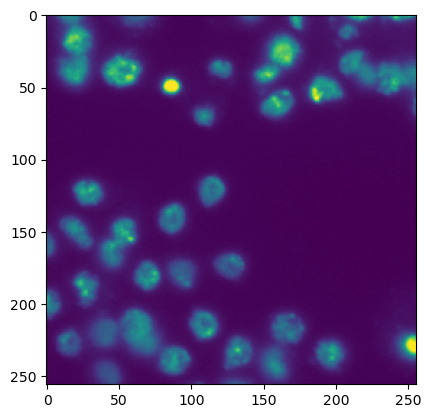

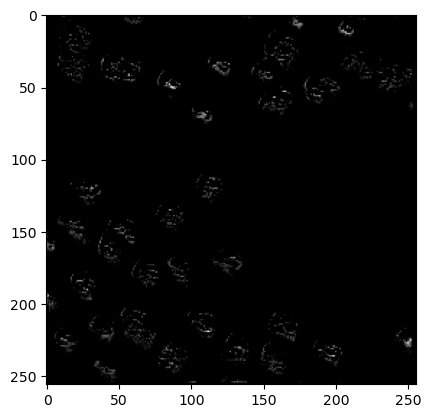

(array([[0.0063689 , 0.        , 0.        , ..., 0.02617206, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 43.36107635498047)

In [ ]:
def build_model() -> UNetDensity:
    model = UNetDensity(in_channels=1, base=16, out_activation="relu")
    return model

best_model = None

def get_best_model(weights_path: str = "best.pt") -> UNetDensity:
    global best_model

    if best_model is not None:
        return best_model

    ckpt = torch.load(weights_path, map_location="cpu")

    model = build_model()
    model.load_state_dict(ckpt["model_state"], strict=True)
    model.eval()

    best_model = model
    return model

@torch.inference_mode()
def predict_with_best(full_image_path: str, show: bool = False, weights_path: str = "best.pt") -> tuple[np.ndarray, float]:
    """
    Runs prediction using best saved model weights.
    """
    model = get_best_model(weights_path=weights_path)
    return predict_image_density_and_count(model, full_image_path, P=256, stride=256, show=show)

test1_img = r"stage1_test\0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732\images\0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732.png"
predict_with_best(test1_img, True)